# Building a Robust Logistic Regression from Scratch with NumPy
**Author:** Alexander Lars Helmich

In this notebook, I implement a full **Binary Logistic Regression** model without using `NumPy` for the core logic. The goal is to understand the mathematics behind classification, gradient descent, and regularization.

### Features
- **Vectorized Implementation**: Uses `NumPy` for efficient matrix operations.
- **Regularization**: Supports **L1 (Lasso)** and **L2 (Ridge)** penalties to prevent overfitting.
- **Optimization**: Automated hyperparameter tuning via **Grid Search** and **K-Fold Cross-Validation**.
- **Stability**: Includes numerical techniques (clipping) to prevent overflow/underflow errors.

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_classification, load_breast_cancer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, confusion_matrix
import seaborn as sns

# Set seed for reproducibility
np.random.seed(42)

## 1. Mathematical Foundation

### The Sigmoid Activation
Logistic regression maps linear outputs to a probability range $(0, 1)$ using the sigmoid function:
$$\sigma(z) = \frac{1}{1 + e^{-z}}$$

### Binary Cross-Entropy Loss (Log Loss)
To train the model, we minimize the difference between predicted probabilities ($\hat{y}$) and actual labels ($y$).
$$J(w, b) = - \frac{1}{m} \sum_{i=1}^{m} [ y^{(i)} \log(\hat{y}^{(i)}) + (1 - y^{(i)}) \log(1 - \hat{y}^{(i)}) ]$$

### Regularization (L1 & L2)
To handle noisy data, we add a penalty term to the Loss function:
- **L1 (Lasso)**: Adds $\lambda \sum |w_j|$. Promotes sparsity (feature selection).
- **L2 (Ridge)**: Adds $\lambda \sum w_j^2$. Prevents large weights (stability).

In [10]:
class LogisticRegression:
    def __init__(self, learning_rate=0.01, n_iters=1000, penalty=None, lambda_param=0.01):
        self.lr = learning_rate
        self.n_iters = n_iters
        self.penalty = penalty
        self.lambda_param = lambda_param
        self.weights = None
        self.bias = None
        self.losses = []

    def _sigmoid(self, z):
        # Clip z to avoid overflow in exp()
        z = np.clip(z, -250, 250)
        return 1 / (1 + np.exp(-z))

    def _compute_loss(self, y_true, y_pred):
        # Clip y_pred to avoid log(0)
        epsilon = 1e-15
        y_pred = np.clip(y_pred, epsilon, 1 - epsilon)
        loss = -np.mean(y_true * np.log(y_pred) + (1 - y_true) * np.log(1 - y_pred))
        
        # Add regularization term to loss for tracking
        if self.penalty == 'l1':
            loss += self.lambda_param * np.sum(np.abs(self.weights))
        elif self.penalty == 'l2':
            loss += (self.lambda_param / 2) * np.sum(self.weights ** 2)
            
        return loss

    def fit(self, X, y):
        n_samples, n_features = X.shape
        self.weights = np.zeros(n_features)
        self.bias = 0
        self.losses = []

        for _ in range(self.n_iters):
            # Forward pass
            linear_model = np.dot(X, self.weights) + self.bias
            y_pred = self._sigmoid(linear_model)
            
            # Compute Loss
            loss = self._compute_loss(y, y_pred)
            self.losses.append(loss)

            # Backward pass (Gradients)
            dw = (1 / n_samples) * np.dot(X.T, (y_pred - y))
            db = (1 / n_samples) * np.sum(y_pred - y)

            # Apply Regularization
            if self.penalty == 'l1':
                dw += (self.lambda_param / n_samples) * np.sign(self.weights)
            elif self.penalty == 'l2':
                dw += (self.lambda_param / n_samples) * 2 * self.weights

            # Update parameters
            self.weights -= self.lr * dw
            self.bias -= self.lr * db

    def predict_proba(self, X):
        linear_model = np.dot(X, self.weights) + self.bias
        return self._sigmoid(linear_model)

    def predict(self, X, threshold=0.5):
        y_pred = self.predict_proba(X)
        return (y_pred >= threshold).astype(int)
    
    def score(self, X, y):
        y_pred = self.predict(X)
        return np.mean(y_pred == y)

## 2. Optimization Utilities
To ensure the model generalizes well, I implemented **K-Fold Cross-Validation** and **Grid Search** manually.

In [4]:
import itertools

def k_fold_cross_validation(model_class, X, y, k=5, **model_params):
    n_samples = len(X)
    indices = np.arange(n_samples)
    np.random.shuffle(indices)
    fold_size = n_samples // k
    accuracies = []

    for i in range(k):
        val_idx = indices[i*fold_size : (i+1)*fold_size]
        train_idx = np.concatenate([indices[:i*fold_size], indices[(i+1)*fold_size:]])
        
        model = model_class(**model_params)
        model.fit(X[train_idx], y[train_idx])
        accuracies.append(model.score(X[val_idx], y[val_idx]))
        
    return np.mean(accuracies)

def grid_search(model_class, X, y, param_grid, cv=5):
    keys, values = zip(*param_grid.items())
    combinations = [dict(zip(keys, v)) for v in itertools.product(*values)]
    
    best_score = -1
    best_params = None
    
    print(f"Searching through {len(combinations)} combinations...")
    
    for params in combinations:
        score = k_fold_cross_validation(model_class, X, y, k=cv, **params)
        if score > best_score:
            best_score = score
            best_params = params
            
    return best_params, best_score

## 3. Real-World Benchmark: Breast Cancer Dataset
I will test the implementation on the **Breast Cancer Wisconsin** dataset and compare it against Scikit-Learn.

Starting optimization...
Searching through 8 combinations...

Best Parameters: {'learning_rate': 0.01, 'n_iters': 1000, 'penalty': 'l1', 'lambda_param': 0.01}
Best CV Accuracy: 0.9758
Final Test Accuracy: 0.9912


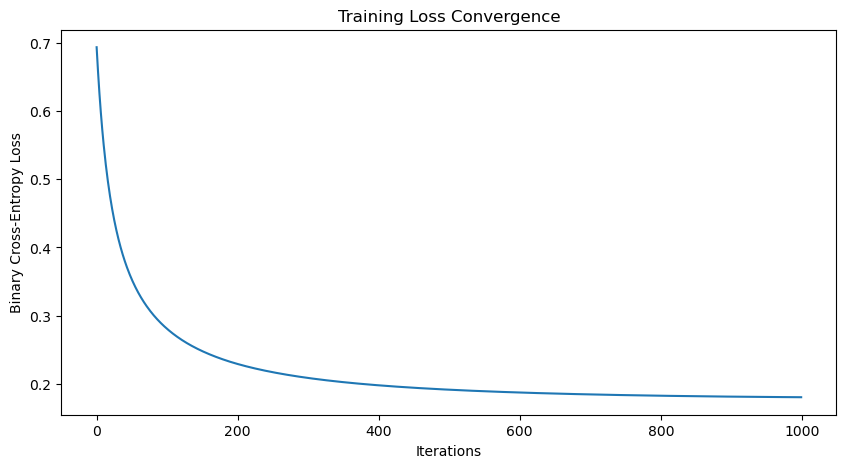

In [11]:
# Load Data
data = load_breast_cancer()
X, y = data.data, data.target

# Normalize Features for GD
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Define Hyperparameters to search
param_grid = {
    'learning_rate': [0.1, 0.01],
    'n_iters': [1000],
    'penalty': ['l2', 'l1'],
    'lambda_param': [0.1, 0.01]
}

# Run Grid Search
print("Starting optimization...")
best_params, best_score = grid_search(LogisticRegression, X_train, y_train, param_grid, cv=5)

print(f"\nBest Parameters: {best_params}")
print(f"Best CV Accuracy: {best_score:.4f}")

# Train Final Model
final_model = LogisticRegression(**best_params)
final_model.fit(X_train, y_train)
test_acc = final_model.score(X_test, y_test)

print(f"Final Test Accuracy: {test_acc:.4f}")

# Plot Loss Curve
plt.figure(figsize=(10, 5))
plt.plot(final_model.losses)
plt.title("Training Loss Convergence")
plt.xlabel("Iterations")
plt.ylabel("Binary Cross-Entropy Loss")
plt.show()